# Описание проекта

Cтажировка в отделе аналитики Яндекс.Афиши. 
Задание: помочь маркетологам оптимизировать маркетинговые затраты.
В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Изучить:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

# Шаги для решения задачи:
## Шаг 1. Загрузите данные и подготовьте их к анализу
* Загрузите данные о визитах, заказах и расходах в переменные. 
* Оптимизируйте данные для анализа. 
* Убедитесь, что тип данных в каждой колонке — правильный. 

## Шаг 2. Постройте отчёты и посчитайте метрики
Продукт
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

Продажи
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

Маркетинг
* Сколько денег потратили? Всего / на каждый источник / по времени
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)

*Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?*

## Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?

* Какие источники/платформы вы бы порекомендовали? 
* Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? 
* Какие выводы вы сделали, узнав значение метрик?

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import math as mt
import timeit 
from matplotlib import pyplot as plt
from scipy import stats as st
from math import factorial
from scipy.stats import norm
import seaborn as sns
ALPHA = 0.05
import warnings
warnings.simplefilter("ignore")

Описание данных

In [2]:
table_visits = {
    "Таблица visits": "(лог сервера с информацией о посещениях сайта):",
    "Uid" : "уникальный идентификатор пользователя",
    "Device" : "категория устройства пользователя",
    "Start Ts" : "дата и время начала сессии",
    "End Ts" : "дата и время окончания сессии",
    "Source Id" : "идентификатор рекламного источника, из которого пришел пользователь"
}

table_orders = {
    'Таблица orders' : '(информация о заказах):',
    'Uid ': 'уникальный id пользователя, который сделал заказ',
    'Buy Ts ': 'дата и время заказа',
    'Revenue' : 'выручка Яндекс.Афиши с этого заказа'
}

table_costs = {
    'Таблица costs': '(информация о затратах на маркетинг):',
    'source_id' : 'идентификатор рекламного источника',
    'dt' : 'дата',
    'costs' : 'затраты на этот рекламный источник в этот день'
}

Описание переменных

# Шаг 1. Загрузите данные и подготовьте их к анализу

* Загрузите данные о визитах, заказах и расходах в переменные.
* Оптимизируйте данные для анализа.
* Убедитесь, что тип данных в каждой колонке — правильный.

## Загрузка данных

In [3]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [5]:
visits['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

Данные заполнены полностью. Формат данных времени сессии не соответствуюет наполнению.

In [6]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
table_orders

{'Таблица orders': '(информация о заказах):',
 'Uid ': 'уникальный id пользователя, который сделал заказ',
 'Buy Ts ': 'дата и время заказа',
 'Revenue': 'выручка Яндекс.Афиши с этого заказа'}

In [8]:
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Данные заполнены полностью. Формат данных даты заказа не соответствуюет наполнению.

In [9]:
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [10]:
table_costs

{'Таблица costs': '(информация о затратах на маркетинг):',
 'source_id': 'идентификатор рекламного источника',
 'dt': 'дата',
 'costs': 'затраты на этот рекламный источник в этот день'}

In [11]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


Данные заполнены полностью. Формат данных даты не соответствуюет наполнению.

## Предобработка данных

Преозование формата времени

In [12]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format="%Y-%m-%d %H:%M:%S")
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format="%Y-%m-%d %H:%M:%S")
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format="%Y-%m-%d %H:%M:%S")
costs['dt'] = pd.to_datetime(costs['dt'])

Выделим год, месяц, день

In [13]:
visits['session_year'] = visits['Start Ts'].dt.year
visits['session_month'] = visits['Start Ts'].dt.month
visits['session_week'] = visits['Start Ts'].dt.week
visits['session_date'] = visits['Start Ts'].dt.date
visits['session_date'] = pd.to_datetime(visits['session_date'])

In [14]:
table_visits['session_year'] = 'Год первой сессий'
table_visits['session_month'] = 'Месяц первой сессий'
table_visits['session_week'] = 'Неделя первой сессий'
table_visits['session_date'] = 'День первой сессий'

# Шаг 2. Постройте отчёты и посчитайте метрики

Продукт
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

Продажи
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

Маркетинг
* Сколько денег потратили? Всего / на каждый источник / по времени
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)

*Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?*

### Продукт

### Сколько новых людей пользуются продуктом в день, неделю, месяц?

DAU

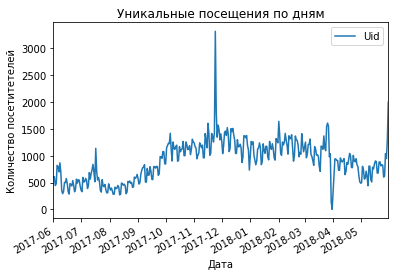

In [15]:
dauplot = visits.groupby('session_date').agg({'Uid':'nunique'}).plot(title='Уникальные посещения по дням');
dauplot.set_xlabel('Дата')
dauplot.set_ylabel('Количество посетитетелей');

Наибольшее количество уникальных посетителей по дням наблюдается в зимнии месяцы.

In [16]:
dau = visits.groupby('session_date').agg({'Uid':'nunique'}).mean()
print(f'Количество уникальных пользователей продукта за день составляет {int(dau[0].round())} человек')

Количество уникальных пользователей продукта за день составляет 908 человек


WAU

In [17]:
visits['session_week_date'] = visits['session_date'].astype('datetime64[W]')

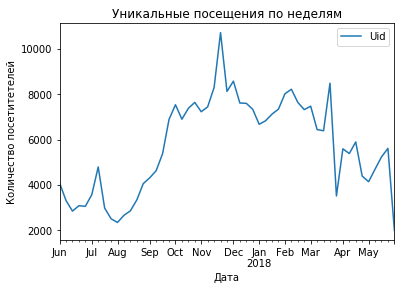

In [18]:
wauplot = visits.groupby(['session_week_date']).agg({'Uid':'nunique'}).plot(title='Уникальные посещения по неделям');
wauplot.set_xlabel('Дата')
wauplot.set_ylabel('Количество посетитетелей');

In [19]:
wau = visits.groupby(['session_year','session_week']).agg({'Uid':'nunique'}).mean()
print(f'Количество уникальных пользователей продукта за неделю составляет {int(wau[0].round())} человек')

Количество уникальных пользователей продукта за неделю составляет 5716 человек


MAU

In [20]:
visits['session_moth_date'] = visits['session_date'].astype('datetime64[M]')

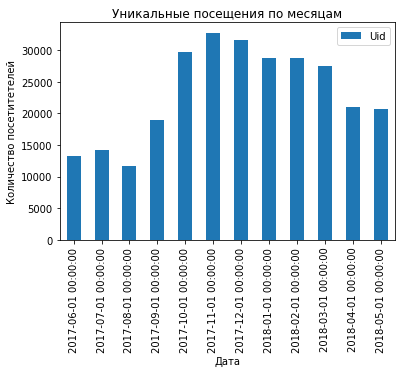

In [21]:
mauplot = (visits
           .groupby(['session_moth_date'])
           .agg({'Uid':'nunique'})
           .plot(kind='bar', 
                 title='Уникальные посещения по месяцам',
     ));
mauplot.set_xlabel('Дата')
mauplot.set_ylabel('Количество посетитетелей');

Количество уникальных сессий значительно возрастает в период с октября по март.

In [22]:
mau = visits.groupby(['session_year','session_month']).agg({'Uid':'nunique'}).mean()
print(f'Количество уникальных пользователей продукта за месяц составляет {int(mau[0].round())} человек')

Количество уникальных пользователей продукта за месяц составляет 23228 человек


In [23]:
print(f'Количество уникальных пользователей продукта за день составляет {int(dau[0].round())} человек')

Количество уникальных пользователей продукта за день составляет 908 человек


### Сколько сессий в день?

In [24]:
day_session_counts = visits.groupby('session_date').agg({'Uid':'count'}).median()
print(f'В среднем сайт за день на сайте зарегистрированно {int(day_session_counts[0].round())} сессий')

В среднем сайт за день на сайте зарегистрированно 1003 сессий


In [25]:
visits['session_start_ts'] = pd.to_datetime(visits['Start Ts'])
visits['session_end_ts'] = pd.to_datetime(visits['End Ts'])
visits['session_day'] = visits['session_start_ts'].dt.day
sessions_per_user = visits.groupby(['session_year', 'session_month','session_day']).agg({'Uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

n_sessions  n_users  sessions_per_user
session_year session_month session_day                                        
2017         6             1                   664      605           1.097521
                           2                   658      608           1.082237
                           3                   477      445           1.071910
                           4                   510      476           1.071429
                           5                   893      820           1.089024
...                                            ...      ...                ...
2018         5             27                  672      620           1.083871
                           28                 1156     1039           1.112608
                           29                 1035      948           1.091772
                           30                 1410     1289           1.093871
                           31                 2256     1997           1.129695

[364 rows x 3 columns]

In [26]:
mean_session = sessions_per_user['sessions_per_user'].mean().round(2)
f'В один день один пользователь проводит на сервисе {mean_session} сессию'

'В один день один пользователь проводит на сервисе 1.08 сессию'

### Сколько длится одна сессия?

Добавим столбец с рачётом длительности каждой сессии используя два метода

In [27]:
visits['duration_session'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds

In [28]:
visits['duration_session_total'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds()

Посмотрим на разброс данных по длительности сессии

In [29]:
visits.describe()

,Source Id,Uid,session_year,session_month,session_week,session_day,duration_session,duration_session_total
count,359400.000000,3.594000e+05,359400.000000,359400.000000,359400.000000,359400.000000,359400.000000,359400.000000
mean,3.750515,9.202557e+18,2017.453395,6.616274,26.970907,16.006377,643.506489,643.025687
std,1.917116,5.298433e+18,0.497824,3.855768,16.773920,8.766358,1016.334786,997.127761
min,1.000000,1.186350e+13,2017.000000,1.000000,1.000000,1.000000,0.000000,-2760.000000
25%,3.000000,4.613407e+18,2017.000000,3.000000,11.000000,8.000000,120.000000,120.000000
50%,4.000000,9.227413e+18,2017.000000,7.000000,26.000000,16.000000,300.000000,300.000000
75%,5.000000,1.372824e+19,2018.000000,10.000000,43.000000,24.000000,840.000000,840.000000
max,10.000000,1.844668e+19,2018.000000,12.000000,52.000000,31.000000,84480.000000,42660.000000


Есть высбросы и некоректные значения, поэтому используем медианы для определения длительности одной сессии. Видно, что метод total_seconds обнаружил отрицательные выбросы. Вероятно, в первоначаьных данных были ошибки записи даты. Удалим сессии, которые менльше нуля и посчитаем среднюю продолжительность сесси.

In [30]:
duration_session_total_not = visits[visits['duration_session_total'] >= 0]

In [31]:
duration_session_total_not['duration_session_total'].describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: duration_session_total, dtype: float64

Построим распределение длительности сессий.

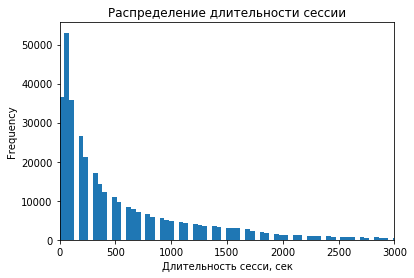

In [32]:
duration_session_total_not_plot = (duration_session_total_not['duration_session_total']
                                   .plot(kind='hist', 
                                         bins=1000,
                                         xlim=(0,3000), 
                                         title= 'Распределение длительности сессии'));
duration_session_total_not_plot.set_xlabel('Длительность сесси, сек');

Видно, что распределение смещено в лево, поэтому для оценки длительной сессии используем значение медианы выборки, чтобы отсечь влияние выбросов.

In [33]:
duration_session = visits['duration_session'].median()
print(f'Одна сессия длится {duration_session} секунд')

Одна сессия длится 300.0 секунд


* Как часто люди возвращаются?

Для ответа на этот вопрос расчитаем коэфициент удержания и увидим,сколько людей возвращается к нашему продукту

Расчитаем для каждого пользователя дату начала использования продукта

In [34]:
first_visit_date = visits.groupby('Uid').agg({'Start Ts':'min'})
first_visit_date.columns = ['first_visit_date']
first_visit_date['first_visit_date'] = first_visit_date['first_visit_date'].dt.date

Соединим таблицы

In [35]:
visits_first_date = pd.merge(visits,first_visit_date, on='Uid')
visits_first_date['first_visit_date'] = pd.to_datetime(visits_first_date['first_visit_date'])
visits_first_date.head()

,Device,End Ts,Source Id,Start Ts,Uid,session_year,session_month,session_week,session_date,session_week_date,session_moth_date,session_start_ts,session_end_ts,session_day,duration_session,duration_session_total,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12-14,2017-12-01,2017-12-20 17:20:00,2017-12-20 17:38:00,20,1080,1080.0,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02-15,2018-02-01,2018-02-19 16:53:00,2018-02-19 17:21:00,19,1680,1680.0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-06-29,2017-07-01,2017-07-01 01:54:00,2017-07-01 01:54:00,1,0,0.0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-05-17,2018-05-01,2018-05-20 10:59:00,2018-05-20 11:23:00,20,1440,1440.0,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,2018-03-08,2018-03-01,2018-03-09 20:05:00,2018-03-09 20:33:00,9,1680,1680.0,2018-03-09


### Частота возвратов

Опредление возвратов на каждый день будет иметь большое количество выходных данных. Поэтому попробуем поределить возврты по месяцам и неделям.

### Возвраты за неделю

Выделим день начала недели.

In [36]:
visits_first_date['activity_week'] = pd.to_datetime(visits_first_date['session_date'], unit='d') - pd.to_timedelta(visits_first_date['session_date'].dt.dayofweek, unit='d')

In [37]:
visits_first_date['first_activity_week'] = pd.to_datetime(visits_first_date['first_visit_date'], unit='d') - pd.to_timedelta(visits_first_date['first_visit_date'].dt.dayofweek, unit='d')

Посмотрим как менялась активность кагорты во времени

In [38]:
visits_first_date_pivot_week = visits_first_date.pivot_table(index='first_activity_week',
    columns='activity_week',
    values='Uid',
    aggfunc='nunique')

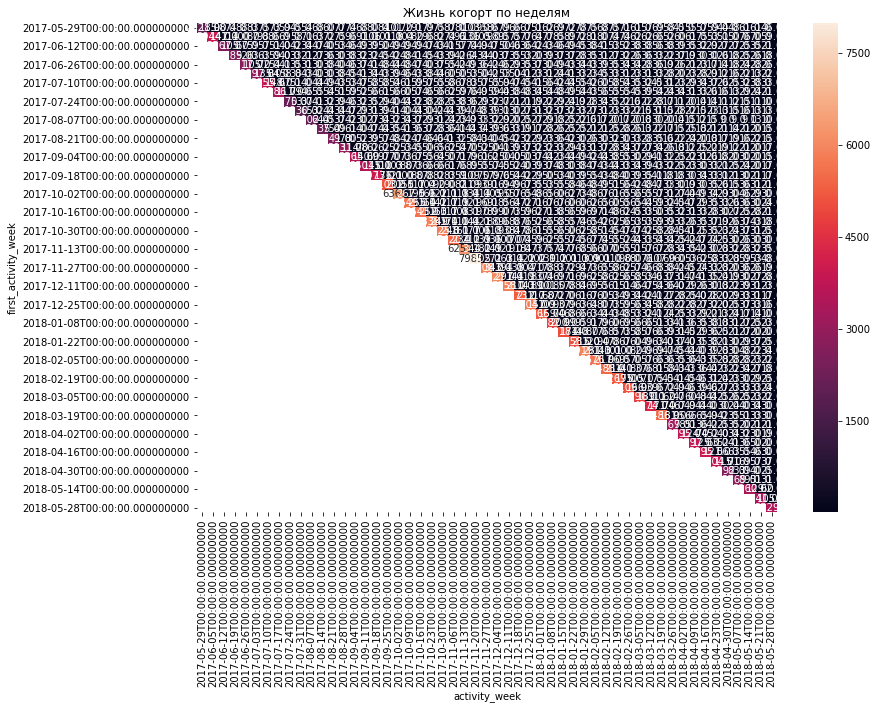

In [39]:
plt.figure(figsize=(13, 9))
plt.title('Жизнь когорт по неделям')
sns.heatmap(visits_first_date_pivot_week, annot=True, fmt='.1f', linewidths=0, linecolor='gray')

#### Расчитаем Retention Rate

Расчитаем lifetime 

In [40]:
visits_first_date['cohort_lifetime_week'] = visits_first_date['activity_week'] - visits_first_date['first_activity_week']
visits_first_date['cohort_lifetime_week'] = visits_first_date['cohort_lifetime_week'] / np.timedelta64(1,'W')
visits_first_date['cohort_lifetime_week'] = visits_first_date['cohort_lifetime_week'].round().astype('int')

Сгруппируем данные по когортам и lifetime и определим количество активных пользователей, которое будет характеризовать количество возвратов пользователей

In [41]:
cohorts_week = visits_first_date.groupby(['first_activity_week','cohort_lifetime_week']).agg({'Uid':'nunique'}).reset_index()

Определим количество пользователей в кагорте на первую неделю

In [42]:
initial_users_count_week = cohorts_week[cohorts_week['cohort_lifetime_week'] == 0][['first_activity_week','Uid']]
initial_users_count_week = initial_users_count_week.rename(columns={'Uid':'cohort_users_week'})

Соединим таблицы с количеством пользователей на первую неделю и таблицей с сгруппирированными данными по еженедельной актинвости пользователей

In [43]:
cohorts_week = cohorts_week.merge(initial_users_count_week,on='first_activity_week')

Расчитаем показатель возврата клиентов (Retention Rate).

In [44]:
cohorts_week['retention_week'] = cohorts_week['Uid']/cohorts_week['cohort_users_week'] * 100

Сгруппирируем данные по первой недели и время жизни.

In [45]:
retention_pivot_week = cohorts_week.pivot_table(index='first_activity_week',columns='cohort_lifetime_week',values='retention_week',aggfunc='sum')
retention_pivot_week

cohort_lifetime_week,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
first_activity_week,,,,,,,,,,,,,,,,,,,,,
2017-05-29,100.0,9.153884,4.849085,3.661554,4.354280,4.106878,3.711034,3.612073,2.919347,2.226620,...,2.869866,2.226620,2.721425,2.820386,2.919347,2.177140,2.375062,3.018308,3.018308,2.276101
2017-06-05,100.0,3.727181,2.890467,2.535497,2.205882,2.484787,2.180527,1.749493,1.470588,1.800203,...,1.521298,1.546653,1.901623,1.343813,1.293103,1.267748,1.926978,1.774848,1.495943,NaN
2017-06-12,100.0,4.090378,2.610051,2.298403,2.220491,1.986755,1.558239,1.636151,1.324503,1.830931,...,1.363459,1.246591,1.129723,1.051811,1.051811,0.973899,1.363459,0.818076,NaN,NaN
2017-06-19,100.0,3.558994,2.437137,2.437137,2.282398,1.547389,1.276596,0.812379,1.044487,1.392650,...,1.160542,1.160542,1.005803,0.696325,0.967118,1.005803,0.696325,NaN,NaN,NaN
2017-06-26,100.0,3.864556,2.649982,1.987486,1.509017,1.288185,1.140964,1.104159,1.398601,1.472212,...,0.625690,0.515274,0.662495,0.883327,1.030548,0.956938,NaN,NaN,NaN,NaN
2017-07-03,100.0,4.659993,2.899551,2.002071,1.311702,1.484294,1.380739,1.035554,1.311702,1.553331,...,0.414222,0.552295,0.759406,0.448740,0.759406,NaN,NaN,NaN,NaN,NaN
2017-07-10,100.0,3.839170,1.738003,1.322957,1.037613,1.141375,1.271077,1.115435,1.374838,1.219196,...,0.648508,0.830091,0.985733,0.856031,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-17,100.0,3.377967,2.404139,1.399878,1.673767,1.643335,1.552039,1.795496,1.582471,1.704200,...,0.882532,0.730371,0.639075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-24,100.0,2.442396,1.705069,1.889401,1.474654,1.797235,2.119816,1.474654,1.612903,1.336406,...,0.506912,0.460829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
retention_pivot_week.describe()

cohort_lifetime_week,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
count,53.0,52.000000,51.000000,50.000000,49.000000,48.000000,47.000000,46.000000,45.000000,44.000000,...,10.000000,9.000000,8.000000,7.000000,6.000000,5.000000,4.000000,3.000000,2.000000,1.000000
mean,100.0,3.921046,2.409437,1.979633,1.706096,1.587864,1.429102,1.340116,1.320084,1.327583,...,1.066661,1.029919,1.225660,1.157205,1.336889,1.276306,1.590456,1.870410,2.257125,2.276101
std,0.0,1.016535,0.690253,0.588960,0.568158,0.589126,0.523858,0.537621,0.482628,0.519810,...,0.734232,0.581982,0.725847,0.784448,0.793904,0.519180,0.725684,1.103225,1.076474,NaN
min,100.0,2.386051,1.401752,1.101254,0.964506,0.764760,0.750939,0.526732,0.500659,0.528479,...,0.414222,0.460829,0.639075,0.448740,0.759406,0.956938,0.696325,0.818076,1.495943,2.276101
25%,100.0,3.297499,1.843529,1.525270,1.365447,1.185125,1.121826,0.930264,1.044487,0.988562,...,0.631395,0.552295,0.735179,0.776178,0.982976,0.973899,1.196676,1.296462,1.876534,2.276101
50%,100.0,3.839228,2.389248,1.886804,1.542112,1.491398,1.320244,1.391617,1.311702,1.308540,...,0.778054,0.830091,0.995768,0.883327,1.041180,1.005803,1.645218,1.774848,2.257125,2.276101
75%,100.0,4.252397,2.901360,2.369383,1.963534,1.969128,1.733771,1.628838,1.598402,1.661810,...,1.312730,1.246591,1.322698,1.197812,1.232780,1.267748,2.038999,2.396578,2.637717,2.276101
max,100.0,9.153884,4.849085,3.661554,4.354280,4.106878,3.711034,3.612073,2.919347,2.743519,...,2.869866,2.226620,2.721425,2.820386,2.919347,2.177140,2.375062,3.018308,3.018308,2.276101


Возвраты клиентов на каждую следующую неделю после начала активности уменьшается. Максимальный возврат клиентов наблюдается для первой кагорты на первую неделю. После возращаются менее 5% пациентов.

### Возвраты за месяц

In [47]:
visits_first_date['first_visit_month'] = visits_first_date['first_visit_date'].astype('datetime64[M]')
visits_first_date['visit_month'] = visits_first_date['session_date'].astype('datetime64[M]')

Расчитаем изменение активности кагорт по месяцам 

In [48]:
visits_first_date_pivot_month = visits_first_date.pivot_table(index='first_visit_month',
    columns='visit_month',
    values='Uid',
    aggfunc='nunique')

In [49]:
visits_first_date_pivot_month_index = visits_first_date_pivot_month.reset_index()
month_cagorts_visits = visits_first_date_pivot_month_index['first_visit_month'].dt.strftime('%Y-%m')


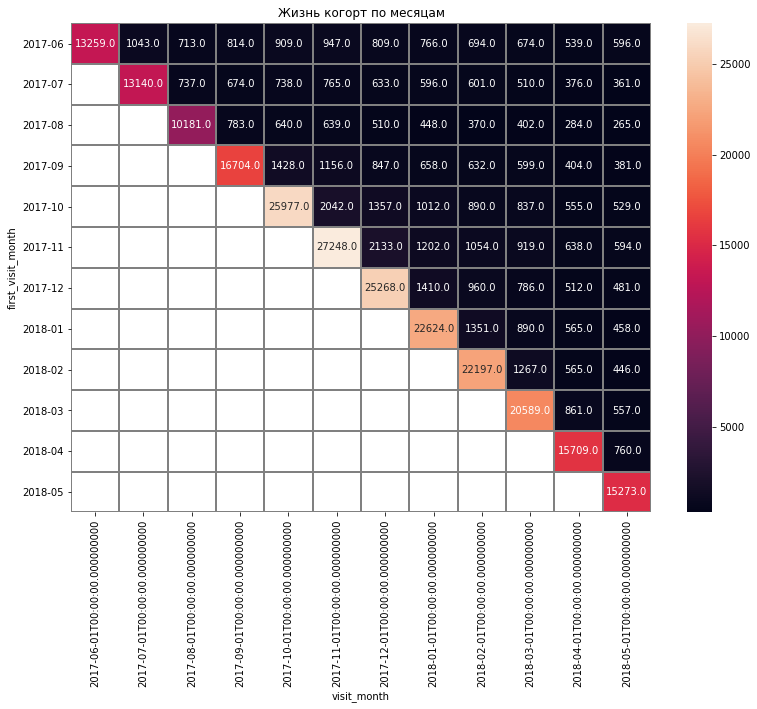

In [50]:
plt.figure(figsize=(13, 9))
plt.title('Жизнь когорт по месяцам')
sns.heatmap(visits_first_date_pivot_month, 
            annot=True, fmt='.1f', 
            linewidths=1, 
            linecolor='gray', 
            yticklabels=month_cagorts_visits);

#### Расчитаем Retention Rate

Расчитаем идентификатор меесяцв в котором произошло собятие у каждого пользователя.

In [51]:
visits_first_date['cohort_lifetime_month'] = visits_first_date['visit_month'] - visits_first_date['first_visit_month']
visits_first_date['cohort_lifetime_month'] = visits_first_date['cohort_lifetime_month'] / np.timedelta64(1,'M')
visits_first_date['cohort_lifetime_month'] = visits_first_date['cohort_lifetime_month'].round().astype('int')

Группируем данные по когорте и показателяю lifetime

In [52]:
cohorts_month = visits_first_date.groupby(['first_visit_month','cohort_lifetime_month']).agg({'Uid':'nunique'}).reset_index()

In [53]:
initial_users_count_month = cohorts_month[cohorts_month['cohort_lifetime_month'] == 0][['first_visit_month','Uid']]
initial_users_count_month = initial_users_count_month.rename(columns={'Uid':'cohort_users'})

In [54]:
cohorts_month = cohorts_month.merge(initial_users_count_month,on='first_visit_month')

In [55]:
cohorts_month['retention_month'] = cohorts_month['Uid'] / cohorts_month['cohort_users']

In [56]:
retention_pivot_month = cohorts_month.pivot_table(index='first_visit_month',columns='cohort_lifetime_month',values='retention_month',aggfunc='sum')

In [57]:
retention_pivot_month_reset_index = retention_pivot_month.reset_index()
month_cagorts = retention_pivot_month_reset_index['first_visit_month'].dt.strftime('%Y-%m')

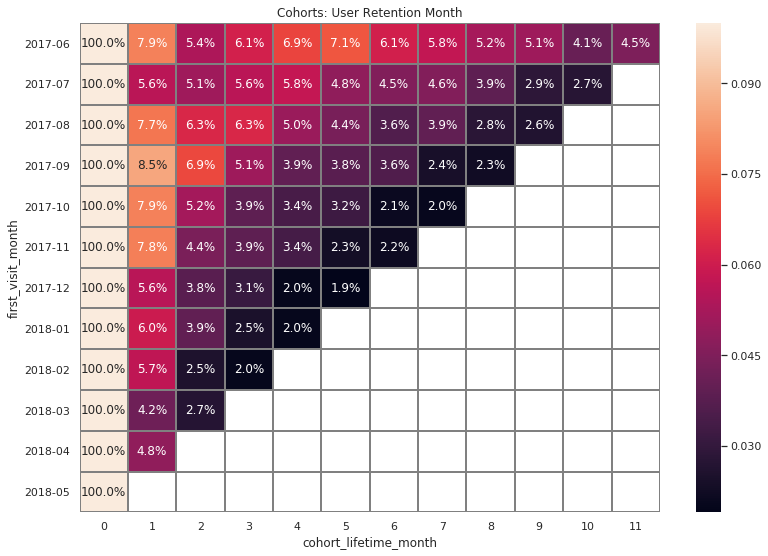

In [58]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention Month')
sns.heatmap(retention_pivot_month, 
            annot=True, fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            yticklabels=month_cagorts, vmax=0.1);

Возврат по месяцам также составляет меньше 10%. Максимальный возврат наблюдается на первый месяц, далее уменьшается до 2% от начальной когорты.

### Продажи

### Когда люди начинают покупать?

In [59]:
first_orders_date = orders.groupby('Uid')['Buy Ts'].min()
first_visit_date_two = visits.groupby('Uid').agg({'Start Ts':'min'})

In [60]:
visit_orders_uid = first_visit_date_two.merge(first_orders_date, on='Uid').reset_index()
visit_orders_uid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 3 columns):
Uid         36523 non-null uint64
Start Ts    36523 non-null datetime64[ns]
Buy Ts      36523 non-null datetime64[ns]
dtypes: datetime64[ns](2), uint64(1)
memory usage: 856.1 KB


In [61]:
visit_orders_uid_seconds = (visit_orders_uid['Buy Ts'] - visit_orders_uid['Start Ts'])

In [62]:
visit_orders_uid_seconds.describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
dtype: object

Переведем данные о времени до первой покупки в секунды и посмотрим на их распределение

In [63]:
visit_orders_uid_seconds.dt.seconds.describe()

count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
dtype: float64

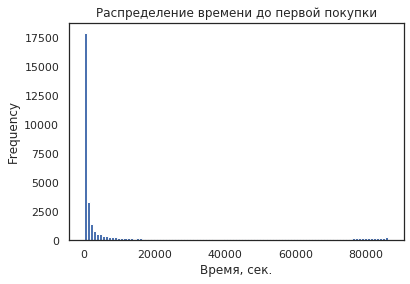

In [64]:
visit_orders_uid_seconds_plot = (visit_orders_uid_seconds
                                 .dt.seconds
                                 .plot(kind='hist', 
                                       bins=100, 
                                       title="Распределение времени до первой покупки"));
visit_orders_uid_seconds_plot.set_xlabel('Время, сек.');

Распределение значительно смещено в влево. Большинство людей, более 75%, покупают в течении первых двух дней после первого посещения сервиса. 

### Сколько раз покупают за период?

Определим количество покупок для каждого пользователя, и усредним показатель. Тем самым оперделим среднее количество осуществляемых покупок 

In [65]:
purchases_per_period = orders.groupby('Uid').agg({'Buy Ts':'count'})

Посмотрим на разброс данных и определим метод которым считать общую характеристику (медиана или среднее)

In [66]:
purchases_per_period.describe(percentiles=[0.80])

,Buy Ts
count,36523.000000
mean,1.380363
std,3.454461
min,1.000000
50%,1.000000
80%,1.000000
max,239.000000


In [67]:
print(f'Cреднее количество покупок для каждого покупателя составляет {purchases_per_period.mean()[0].round(2)}, но  в данных имеется значительный разброс, а более 80% людей делали покупку один раз')

Cреднее количество покупок для каждого покупателя составляет 1.38, но  в данных имеется значительный разброс, а более 80% людей делали покупку один раз


### Какой средний чек?

#### Расчитаем средний доход с одного платящего пользователя

Вычислим первую дату покупки и добавим её к основному датасету покупок.

In [68]:
first_orders_date.name = 'first_order_date'
orders = orders.join(first_orders_date,on='Uid')

Перформатируем данные в стоблцах с датами для удобства расчётов

In [69]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')

Вычислим по кагортам прибыль и количество уникальных покупателей

In [70]:
orders_grouped_cohorts = orders.groupby(['first_order_month','order_month']).agg({'Revenue':'sum','Uid':'nunique'})

Посчитаем средний доход с одного платящего пользователя

In [71]:
orders_grouped_cohorts['ARPPU'] = orders_grouped_cohorts['Revenue'] / orders_grouped_cohorts['Uid']

Группируем данные по среднему доходу с одного платящего пользователя

In [72]:
orders_grouped_cohorts_pivot_table = orders_grouped_cohorts.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='ARPPU',
    aggfunc='mean')
orders_grouped_cohorts_pivot_table

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


Расчитаем время жизни кагорт

In [73]:
orders_grouped_cohorts = orders_grouped_cohorts.reset_index()
orders_grouped_cohorts['cohort_lifetime'] = orders_grouped_cohorts['order_month'] - orders_grouped_cohorts['first_order_month']

In [74]:
orders_grouped_cohorts['cohort_lifetime'] = orders_grouped_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

In [75]:
orders_grouped_cohorts['cohort_lifetime'] = orders_grouped_cohorts['cohort_lifetime'].round().astype('int')

Сгруппируем данные по кагортам и оцценим средний доход с одного платящего пользователя

In [76]:
revenue_per_user_pivot = orders_grouped_cohorts.pivot_table(index='first_order_month',
                                                            columns='cohort_lifetime',
                                                            values='ARPPU',
                                                            aggfunc='mean')
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09-01,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10-01,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11-01,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
revenue_per_user_pivot_index = revenue_per_user_pivot.reset_index()
month_cagorts_check = revenue_per_user_pivot_index['first_order_month'].dt.strftime('%Y-%m')

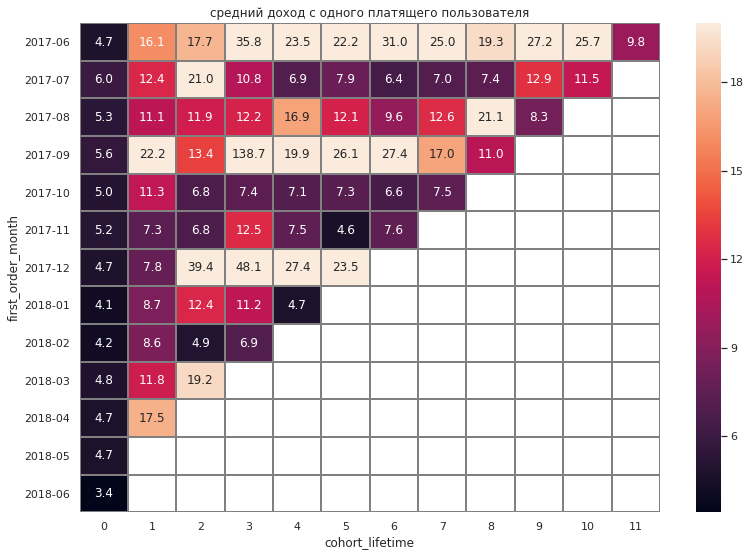

In [78]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('средний доход с одного платящего пользователя')
sns.heatmap(revenue_per_user_pivot, 
            annot=True, fmt='.1f', 
            linewidths=1, 
            linecolor='gray', 
            vmax=20, 
            yticklabels=month_cagorts_check);

#### Расчитаем средний чек

Вычислим по кагортам прибыль и количество покупок в целом за период

In [79]:
orders_grouped_cohorts_user_count = orders.groupby(['first_order_month','order_month']).agg({'Revenue':'sum','Uid':'count'})

In [80]:
orders_grouped_cohorts_user_count['revenue_per_user'] = orders_grouped_cohorts_user_count['Revenue'] / orders_grouped_cohorts_user_count['Uid']

Группируем данные и оценим покагортно средний чек

In [81]:
orders_grouped_cohorts_pivot_table_user_count = orders_grouped_cohorts_user_count.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='revenue_per_user',
    aggfunc='mean')
orders_grouped_cohorts_pivot_table_user_count

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.060106,5.547006,5.088161,8.545575,7.084178,6.825321,6.966449,6.761839,5.279009,8.009869,12.038125,6.042093,NaN
2017-07-01,NaN,5.287123,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,NaN,NaN,4.715479,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN
2017-09-01,NaN,NaN,NaN,4.967109,13.171187,8.351056,62.570244,15.430448,15.321835,16.767130,11.206607,7.785574,NaN
2017-10-01,NaN,NaN,NaN,NaN,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.370717,4.103955,4.474670,6.284976,4.441471,3.726780,4.598235,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.110746,4.226741,20.072772,26.084358,15.948488,14.111048,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.687417,4.438482,6.454969,7.524844,2.711282,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.706266,4.576486,3.453735,3.867143,NaN


Расчитаем время жизни кагорты

In [82]:
orders_grouped_cohorts_user_count = orders_grouped_cohorts_user_count.reset_index()
orders_grouped_cohorts_user_count['cohort_lifetime'] = orders_grouped_cohorts_user_count['order_month'] - orders_grouped_cohorts['first_order_month']

In [83]:
orders_grouped_cohorts_user_count['cohort_lifetime'] = orders_grouped_cohorts_user_count['cohort_lifetime'] / np.timedelta64(1,'M')

Сгруппируем данные по времени жизни

In [84]:
orders_grouped_cohorts_user_count['cohort_lifetime'] = orders_grouped_cohorts_user_count['cohort_lifetime'].round().astype('int')

In [85]:
revenue_per_user_pivot_user_count = orders_grouped_cohorts_user_count.pivot_table(index='first_order_month',
                                                            columns='cohort_lifetime',
                                                            values='revenue_per_user',
                                                            aggfunc='mean')
revenue_per_user_pivot_user_count

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.060106,5.547006,5.088161,8.545575,7.084178,6.825321,6.966449,6.761839,5.279009,8.009869,12.038125,6.042093
2017-07-01,5.287123,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,4.715479,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN,NaN
2017-09-01,4.967109,13.171187,8.351056,62.570244,15.430448,15.321835,16.767130,11.206607,7.785574,NaN,NaN,NaN
2017-10-01,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN,NaN,NaN,NaN
2017-11-01,4.370717,4.103955,4.474670,6.284976,4.441471,3.726780,4.598235,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.110746,4.226741,20.072772,26.084358,15.948488,14.111048,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.687417,4.438482,6.454969,7.524844,2.711282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.706266,4.576486,3.453735,3.867143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
revenue_per_user_pivot_index_user_count = revenue_per_user_pivot_user_count.reset_index()
month_cagorts_check_user_count = revenue_per_user_pivot_index_user_count['first_order_month'].dt.strftime('%Y-%m')

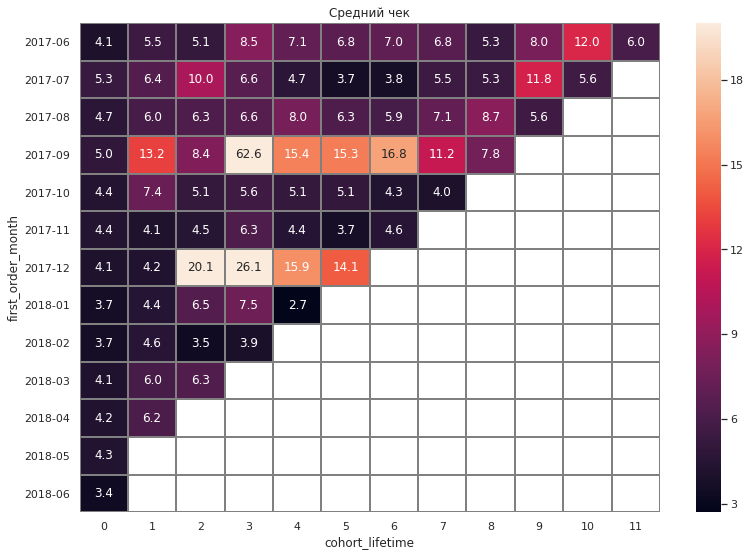

In [87]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
sns.heatmap(revenue_per_user_pivot_user_count, 
            annot=True, fmt='.1f', 
            linewidths=1, 
            linecolor='gray', 
            vmax=20, 
            yticklabels=month_cagorts_check_user_count);

Июньская, сентябрьская и декабрьская кагорты имеют высокие показатели как по среднему чеку, так и по среднему доходу с одного платящего пользователя. Причём максимумы в обоих случаях приходится на 3 месяц жизни кагорты.

### Сколько денег приносят? (LTV)

Определим количество уникальных покупателей к каждой кагорте

In [88]:
cohort_sizes = orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Расчитаем сумму прибыли с каждой кагорты на каждый месяц

In [89]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


Объединим данные

In [90]:
report = cohorts.merge(cohort_sizes, on='first_order_month')

Для дальнейшего расчёта необходимы данные о маржинальности, т.к. расчёт LTV проводится по валовой прибыли. Так как данных о маржинальности отсутсвуют, преположим, что она равна 100%. 
Так же удобно расчитывать этот показатель по возратным кагортам.

In [91]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Расчитаем ltv поделив прибыль по каждой кагорте на количествокользователей в ней.

In [92]:
report['ltv'] = report['Revenue'] / report['n_buyers']
report

,first_order_month,order_month,Revenue,n_buyers,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,1,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,0,4.660562


In [93]:
output_ltv = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
output_ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
output_ltv = output_ltv.cumsum(axis=1).round(2)

In [95]:
output_ltv_reset_index = output_ltv.reset_index()
month_ltv = output_ltv_reset_index['first_order_month'].dt.strftime('%Y-%m')

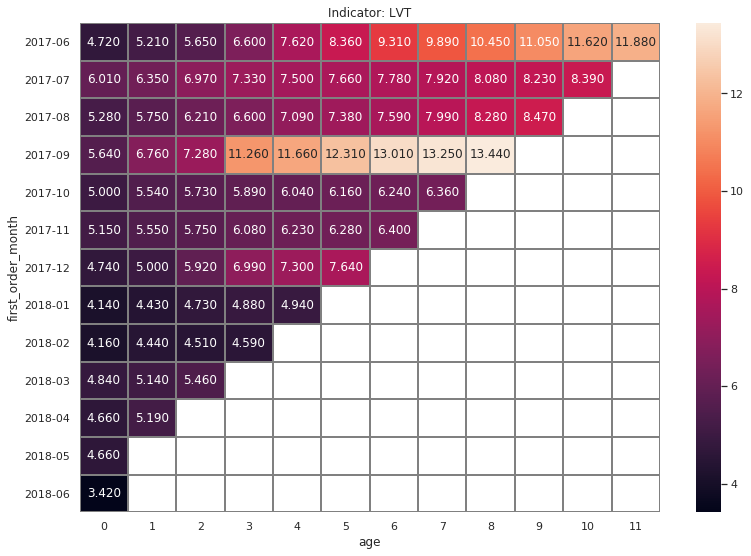

In [96]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Indicator: LVT')
sns.heatmap(output_ltv, 
            annot=True, 
            fmt='.3f', 
            linewidths=1, 
            linecolor='gray', 
            yticklabels=month_ltv);

Полльзователи из первых кагорт принесили за исследуемый период большое количество прибыли. Причём пользователи сентябрьской кагорты принесли максимальный даход, превышающий даход с кагорт имеющих юолее длиный срок жизни.

### Маркетинг
За весь период все аппараты

### Сколько денег потратили? 

Общая сумма затрат на привлечение клиентов.

In [97]:
sum_costs = costs['costs'].sum()
f'Общая сумма завтра на привлечение клиентов составляет {sum_costs}'

'Общая сумма завтра на привлечение клиентов составляет 329131.62'

Расходы по каждому источнику

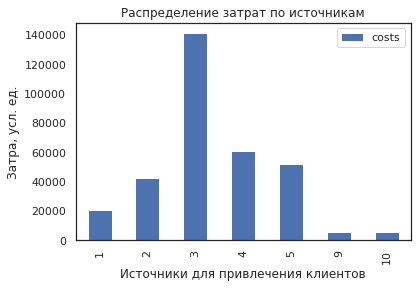

In [98]:
costs_sum_souid = costs.groupby('source_id')['costs'].sum().reset_index()

costs_sum_souid_plot = costs_sum_souid.plot(x='source_id', 
                     y='costs', 
                     kind='bar', 
                     title='Распределение затрат по источникам')
costs_sum_souid_plot.set_ylabel('Затра, усл. ед.')
costs_sum_souid_plot.set_xlabel('Источники для привлечения клиентов');

За весь период основные затраты пришлись на истоник номер 3, значительную долю занимают источники 2,4,5.

### Сколько стоило привлечение одного покупателя из каждого источника?

In [99]:
orders['first_order_date'] = orders['first_order_date'].dt.date

Отберем тех кто совершил покупки в первую сессию, чтобы определить источник привлечения клиента.

In [100]:
visits_first_date['bool'] = (visits_first_date['first_visit_date'].dt.date == visits_first_date['session_end_ts'].dt.date)

In [101]:
visits_first_date_only_first = visits_first_date.query('bool>0')

In [102]:
visits_orders = orders.merge(visits_first_date_only_first, on='Uid')

Определим количество уникальных покупателей

In [103]:
visits_orders_only = visits_orders[['Revenue','Uid','first_order_date','Source Id']]
number_of_users = visits_orders_only.groupby('Source Id')['Uid'].nunique()

In [104]:
number_of_users

Source Id
1      4001
2      3856
3     10614
4     10448
5      7612
7         1
9      1096
10     1350
Name: Uid, dtype: int64

Определим кольисество затрат на каждый источник

In [105]:
result_costs = costs.groupby('source_id')['costs'].sum()
result_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Расчитаем затраты на привлечение в среднем на каждого клиента

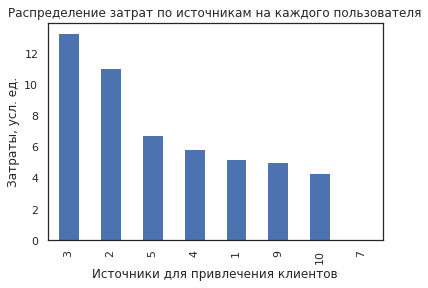

In [106]:
result_costs_for_users = result_costs / number_of_users
result_costs_for_users = result_costs_for_users.sort_values(ascending=False)

result_costs_for_users_plot = result_costs_for_users.plot(x='source_id', 
                     y='costs', 
                     kind='bar', 
                     title='Распределение затрат по источникам на каждого пользователя')
result_costs_for_users_plot.set_ylabel('Затраты, усл. ед.')
result_costs_for_users_plot.set_xlabel('Источники для привлечения клиентов');

Максимальные затраты на привлечения одного клиента за весь период приходится на 2 и 3 источники.

### На сколько окупились расходы? (ROI)

#### Суммарная эффективность бизнеса

Расчитаем прибыль на источник

In [107]:
result_revenue =visits_orders_only.groupby('Source Id')['Revenue'].sum()
result_revenue

Source Id
1     48801.97
2     70509.37
3     57526.86
4     60207.80
5     64006.88
7         1.22
9      6011.06
10     5357.78
Name: Revenue, dtype: float64

Расчитаем возврат на макркетинг по истоникам за весь период

In [108]:
romi = result_revenue/result_costs
romi

1     2.342502
2     1.647183
3     0.407063
4     0.985824
5     1.236678
7          NaN
9     1.089456
10    0.920187
dtype: float64

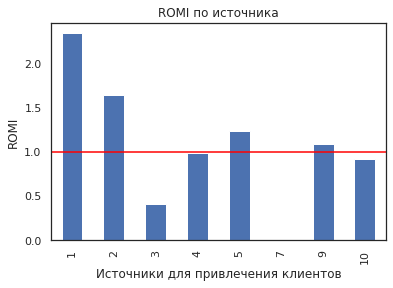

In [109]:
romi = result_revenue/result_costs
romi_plot = romi.plot(x='source_id', 
                     y='costs', 
                     kind='bar', 
                     title='ROMI по источника')
romi_plot.set_ylabel('ROMI')
romi_plot.set_xlabel('Источники для привлечения клиентов');
plt.hlines(1, xmin=-1, xmax=10, color='red');

На графике видно, что только 1, 2, 5 и 9 источники пересекают уровень единицы, что значит привличения клиентов в них окупается и приносит прибыль

#### Расчитаем стоимость привлечения посетителя по источникам

In [110]:
result_uid_count =visits_orders_only.groupby('Source Id')['Uid'].count()
result_uid_count

Source Id
1      8344
2      8163
3     14057
4     13762
5     12044
7         1
9      1712
10     1710
Name: Uid, dtype: int64

In [111]:
price_user = result_costs / result_uid_count
price_user

1      2.496797
2      5.243910
3     10.053470
4      4.437843
5      4.297335
7           NaN
9      3.222833
10     3.404965
dtype: float64

In [112]:
costs_month = costs
costs_month['dt'] = costs_month['dt'].astype('datetime64[M]')
costs_month

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-01,62.25
2,1,2017-06-01,36.53
3,1,2017-06-01,55.00
4,1,2017-06-01,57.08
...,...,...,...
2537,10,2018-05-01,9.92
2538,10,2018-05-01,21.26
2539,10,2018-05-01,11.32
2540,10,2018-05-01,33.15


In [113]:
monthly_costs = costs_month.groupby('dt').sum()

In [114]:
monthly_costs

,source_id,costs
dt,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88
2017-11-01,1020,37907.88
2017-12-01,1054,38315.35
2018-01-01,1054,33518.52
2018-02-01,952,32723.03


Объединим таблицы и посчитаем CAC

In [115]:
report_new = pd.merge(report, monthly_costs, left_on='order_month', right_on='dt')

In [116]:
report_new

,first_order_month,order_month,Revenue,n_buyers,age,ltv,source_id,costs
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414,1020,18015.00
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329,1054,18240.59
2,2017-07-01,2017-07-01,11557.65,1923,0,6.010218,1054,18240.59
3,2017-06-01,2017-08-01,885.34,2023,2,0.437637,1054,14790.54
4,2017-07-01,2017-08-01,644.61,1923,1,0.335211,1054,14790.54
...,...,...,...,...,...,...,...,...
73,2018-01-01,2018-05-01,211.48,3373,4,0.062698,1054,22224.27
74,2018-02-01,2018-05-01,270.70,3651,3,0.074144,1054,22224.27
75,2018-03-01,2018-05-01,1114.87,3533,2,0.315559,1054,22224.27
76,2018-04-01,2018-05-01,1209.92,2276,1,0.531599,1054,22224.27


In [117]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['cac']

0     8.905091
1     9.016604
2     9.485486
3     7.311191
4     7.691388
        ...   
73    6.588873
74    6.087173
75    6.290481
76    9.764618
77    7.437841
Name: cac, Length: 78, dtype: float64

#### Расчёт ROMI по аппратам

Отберем данные по аппаратам

In [118]:
visits_orders_desktop = visits_orders.query('Device == "desktop" & bool>0')
visits_orders_touch = visits_orders.query('Device == "touch" & bool>0')

In [119]:
visits_orders

,Buy Ts,Revenue,Uid,first_order_date,first_order_month,order_month,Device,End Ts,Source Id,Start Ts,...,duration_session,duration_session_total,first_visit_date,activity_week,first_activity_week,cohort_lifetime_week,first_visit_month,visit_month,cohort_lifetime_month,bool
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,...,120,120.0,2017-06-01,2017-05-29,2017-05-29,0,2017-06-01,2017-06-01,0,True
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,...,660,660.0,2017-06-01,2017-05-29,2017-05-29,0,2017-06-01,2017-06-01,0,True
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,...,540,540.0,2017-06-01,2017-05-29,2017-05-29,0,2017-06-01,2017-06-01,0,True
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,...,1140,1140.0,2017-06-01,2017-05-29,2017-05-29,0,2017-06-01,2017-06-01,0,True
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,...,1680,1680.0,2017-06-01,2017-05-29,2017-05-29,0,2017-06-01,2017-06-01,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59788,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-31,2018-05-01,2018-05-01,desktop,2017-12-07 23:26:00,2,2017-12-07 23:20:00,...,360,360.0,2017-12-07,2017-12-04,2017-12-04,0,2017-12-01,2017-12-01,0,True
59789,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-01,2018-05-01,touch,2018-05-31 09:12:00,4,2018-05-31 09:11:00,...,60,60.0,2018-05-31,2018-05-28,2018-05-28,0,2018-05-01,2018-05-01,0,True
59790,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-01,2018-05-01,desktop,2018-05-31 23:55:00,10,2018-05-31 23:05:00,...,3000,3000.0,2018-05-31,2018-05-28,2018-05-28,0,2018-05-01,2018-05-01,0,True
59791,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-01,2018-05-01,desktop,2018-05-31 23:55:00,3,2018-05-31 23:52:00,...,180,180.0,2018-05-31,2018-05-28,2018-05-28,0,2018-05-01,2018-05-01,0,True


Сгруппируем данныеы по прибыли по каждому типу аппаратов

In [120]:
revenue_desktop = visits_orders_desktop.groupby(['first_order_month','order_month']).agg({'Revenue':'sum'}).reset_index()
revenue_desktop

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,11061.55
1,2017-06-01,2017-07-01,1282.17
2,2017-06-01,2017-08-01,1056.83
3,2017-06-01,2017-09-01,2550.60
4,2017-06-01,2017-10-01,2716.71
...,...,...,...
73,2018-03-01,2018-04-01,833.32
74,2018-03-01,2018-05-01,1300.14
75,2018-04-01,2018-04-01,10510.14
76,2018-04-01,2018-05-01,2864.90


In [121]:
revenue_touch = visits_orders_touch.groupby(['first_order_month','order_month'])['Revenue'].sum().reset_index()
revenue_touch

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,1467.21
1,2017-06-01,2017-07-01,101.22
2,2017-06-01,2017-08-01,52.86
3,2017-06-01,2017-09-01,56.32
4,2017-06-01,2017-10-01,98.58
...,...,...,...
73,2018-03-01,2018-04-01,542.28
74,2018-03-01,2018-05-01,230.57
75,2018-04-01,2018-04-01,2211.52
76,2018-04-01,2018-05-01,51.47


Посчиатем количество пользователей в месяц с каждого типа аппаратов

In [122]:
visits_orders_desktop_nunique = visits_orders_desktop.groupby('first_order_month')['Uid'].nunique()

In [123]:
visits_orders_touch_nunique = visits_orders_touch.groupby('first_order_month')['Uid'].nunique()

Расчитаем затьраты на привлечение клиентов по месяцам

In [124]:
costs_month = costs
costs_month['first_order_month'] = costs_month['dt'].astype('datetime64[M]')
costs_month = costs_month.groupby('first_order_month')['costs'].sum().reset_index()
costs_month

,first_order_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Объединим данные по пользователях и посчитаем долю каждого типа аппарата в общей массе клиентов.

In [125]:
visits_orders_nunique = pd.merge(visits_orders_desktop_nunique, visits_orders_touch_nunique, on='first_order_month').reset_index()

In [126]:
visits_orders_nunique.columns = ['first_order_month', 'desktop_nunique', 'touch_nunique']

In [127]:
visits_orders_nunique['sum_nunique'] = visits_orders_nunique['desktop_nunique'] + visits_orders_nunique['touch_nunique']
visits_orders_nunique['part_desktop_nunique'] = visits_orders_nunique['desktop_nunique'] / visits_orders_nunique['sum_nunique']
visits_orders_nunique['part_touch_nunique'] = visits_orders_nunique['touch_nunique'] / visits_orders_nunique['sum_nunique']
visits_orders_nunique

,first_order_month,desktop_nunique,touch_nunique,sum_nunique,part_desktop_nunique,part_touch_nunique
0,2017-06-01,1700,325,2025,0.839506,0.160494
1,2017-07-01,1527,397,1924,0.793659,0.206341
2,2017-08-01,1114,258,1372,0.811953,0.188047
3,2017-09-01,2057,523,2580,0.797287,0.202713
4,2017-10-01,3527,811,4338,0.813047,0.186953
5,2017-11-01,3317,748,4065,0.815990,0.184010
6,2017-12-01,3484,889,4373,0.796707,0.203293
7,2018-01-01,2647,692,3339,0.792752,0.207248
8,2018-02-01,2808,839,3647,0.769948,0.230052
9,2018-03-01,2762,756,3518,0.785105,0.214895


Объединим полученную таблицу с данными по затратам на привлечение и расчяитаем завтраты на привлечение по каждому типу аппартов

In [128]:
costs_nunique_month = pd.merge(costs_month, visits_orders_nunique, on='first_order_month')
costs_nunique_month['costs_desktop_nunique'] = costs_nunique_month['costs'] * costs_nunique_month['part_desktop_nunique']
costs_nunique_month['costs_touch_nunique'] = costs_nunique_month['costs'] * costs_nunique_month['part_touch_nunique']

In [129]:
costs_desktop = costs_nunique_month[['first_order_month','costs_desktop_nunique','desktop_nunique']]
costs_touch = costs_nunique_month[['first_order_month','costs_touch_nunique','touch_nunique']]

Объедим данные по затратам и прибыли по каждому типу аппаратов и расчитаем окупаемость

##### desktop 

In [130]:
romi_desktop = revenue_desktop.merge(costs_desktop, on='first_order_month')
romi_desktop

,first_order_month,order_month,Revenue,costs_desktop_nunique,desktop_nunique
0,2017-06-01,2017-06-01,11061.55,15123.703704,1700
1,2017-06-01,2017-07-01,1282.17,15123.703704,1700
2,2017-06-01,2017-08-01,1056.83,15123.703704,1700
3,2017-06-01,2017-09-01,2550.60,15123.703704,1700
4,2017-06-01,2017-10-01,2716.71,15123.703704,1700
...,...,...,...,...,...
73,2018-03-01,2018-04-01,833.32,23879.185827,2762
74,2018-03-01,2018-05-01,1300.14,23879.185827,2762
75,2018-04-01,2018-04-01,10510.14,18097.205219,1839
76,2018-04-01,2018-05-01,2864.90,18097.205219,1839


In [131]:
romi_desktop['ltv'] = romi_desktop['Revenue'] / romi_desktop['desktop_nunique']
romi_desktop['cac'] = romi_desktop['costs_desktop_nunique'] / romi_desktop['desktop_nunique']
romi_desktop['romi'] = romi_desktop['ltv'] / romi_desktop['cac']
romi_desktop['order_month'] = romi_desktop['order_month'].astype('datetime64[M]')
romi_desktop['first_order_month'] = romi_desktop['first_order_month'].astype('datetime64[M]')
romi_desktop['age'] = ((romi_desktop['order_month'] - romi_desktop['first_order_month']) / np.timedelta64(1, 'M')).round()
romi_desktop

,first_order_month,order_month,Revenue,costs_desktop_nunique,desktop_nunique,ltv,cac,romi,age
0,2017-06-01,2017-06-01,11061.55,15123.703704,1700,6.506794,8.896296,0.731405,0.0
1,2017-06-01,2017-07-01,1282.17,15123.703704,1700,0.754218,8.896296,0.084779,1.0
2,2017-06-01,2017-08-01,1056.83,15123.703704,1700,0.621665,8.896296,0.069879,2.0
3,2017-06-01,2017-09-01,2550.60,15123.703704,1700,1.500353,8.896296,0.168649,3.0
4,2017-06-01,2017-10-01,2716.71,15123.703704,1700,1.598065,8.896296,0.179633,4.0
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,833.32,23879.185827,2762,0.301709,8.645614,0.034897,1.0
74,2018-03-01,2018-05-01,1300.14,23879.185827,2762,0.470724,8.645614,0.054447,2.0
75,2018-04-01,2018-04-01,10510.14,18097.205219,1839,5.715139,9.840786,0.580760,0.0
76,2018-04-01,2018-05-01,2864.90,18097.205219,1839,1.557858,9.840786,0.158306,1.0


In [132]:
output_desktop_romi = romi_desktop.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output_desktop_romi =output_desktop_romi.cumsum(axis=1).round(3)

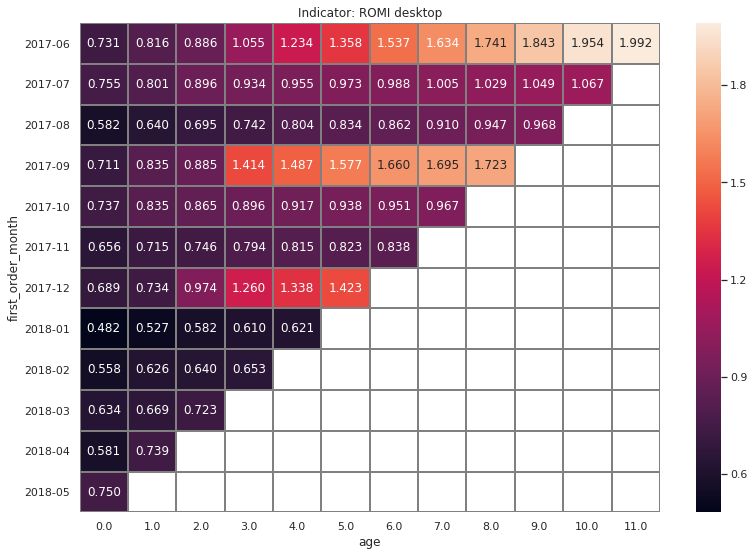

In [133]:
output_desktop_romi_reset_index = output_desktop_romi.reset_index()
month_desktop_romi = output_desktop_romi_reset_index['first_order_month'].dt.strftime('%Y-%m')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Indicator: ROMI desktop')
sns.heatmap(output_desktop_romi, 
            annot=True, 
            fmt='.3f', 
            linewidths=1, 
            linecolor='gray', 
            yticklabels=month_desktop_romi);

За весь период только четыре кагорты оказались прибыльными и спользованием аппартаов desktop. Декабрьская, сентябрьсакя, июльская и июньская. Эти кагорты начали окупатьяс тлько с третьего месяца жизни.

##### touch

In [134]:
romi_touch = revenue_touch.merge(costs_touch, on='first_order_month')
romi_touch

,first_order_month,order_month,Revenue,costs_touch_nunique,touch_nunique
0,2017-06-01,2017-06-01,1467.21,2891.296296,325
1,2017-06-01,2017-07-01,101.22,2891.296296,325
2,2017-06-01,2017-08-01,52.86,2891.296296,325
3,2017-06-01,2017-09-01,56.32,2891.296296,325
4,2017-06-01,2017-10-01,98.58,2891.296296,325
...,...,...,...,...,...
73,2018-03-01,2018-04-01,542.28,6536.084173,756
74,2018-03-01,2018-05-01,230.57,6536.084173,756
75,2018-04-01,2018-04-01,2211.52,4192.174781,426
76,2018-04-01,2018-05-01,51.47,4192.174781,426


In [135]:
romi_touch['ltv'] = romi_touch['Revenue'] / romi_touch['touch_nunique']
romi_touch['cac'] = romi_touch['costs_touch_nunique'] / romi_touch['touch_nunique']
romi_touch['romi'] = romi_touch['ltv'] / romi_touch['cac']

In [136]:
romi_touch['order_month'] = romi_touch['order_month'].astype('datetime64[M]')
romi_touch['first_order_month'] = romi_touch['first_order_month'].astype('datetime64[M]')
romi_touch['age'] = ((romi_touch['order_month'] - romi_touch['first_order_month']) / np.timedelta64(1, 'M')).round()

In [137]:
romi_touch_pivot = romi_touch.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

romi_touch_pivot =romi_touch_pivot.cumsum(axis=1).round(3)

In [138]:
romi_touch_pivot

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,0.507,0.542,0.561,0.580,0.614,0.619,0.625,0.628,0.635,0.666,0.673,0.727
2017-07-01,0.727,0.758,0.768,0.813,0.836,0.850,0.856,0.873,0.883,0.893,0.907,NaN
2017-08-01,0.595,0.607,0.625,0.642,0.652,0.676,0.698,0.711,0.716,0.725,NaN,NaN
2017-09-01,0.642,0.842,0.944,0.998,1.007,1.027,1.174,1.204,1.209,NaN,NaN,NaN
2017-10-01,0.616,0.667,0.682,0.689,0.705,0.709,0.714,0.721,NaN,NaN,NaN,NaN
2017-11-01,0.749,0.765,0.773,0.783,0.795,0.798,0.801,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.539,0.560,0.568,0.578,0.581,0.585,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.448,0.462,0.471,0.479,0.481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.512,0.531,0.535,0.537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


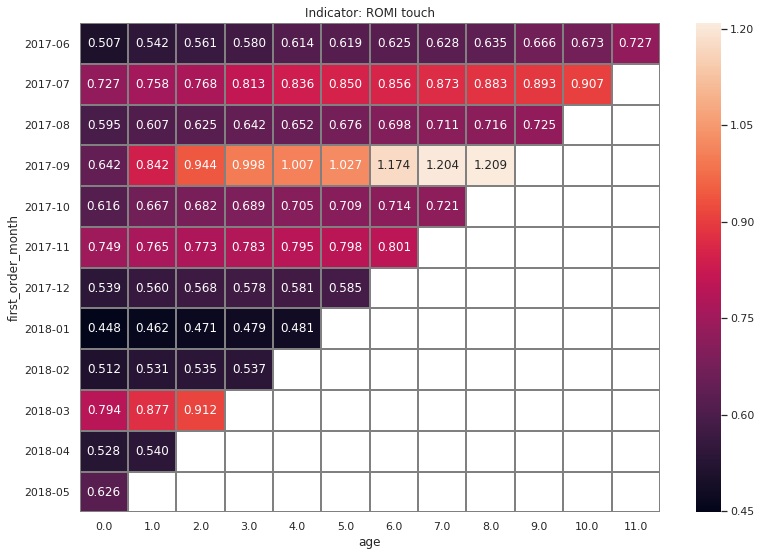

In [139]:
romi_touch_pivot_reset_index = romi_touch_pivot.reset_index()
month_desktop_romi = romi_touch_pivot_reset_index['first_order_month'].dt.strftime('%Y-%m')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Indicator: ROMI touch')
sns.heatmap(romi_touch_pivot, 
            annot=True, 
            fmt='.3f', 
            linewidths=1, 
            linecolor='gray', 
            yticklabels=month_desktop_romi);

За весь период только сентябрьская кагорта оказалась прибыльной с пользованием аппаратов touch. 

#### Расчёт возрата средств по времени

In [140]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [141]:
report_new

,first_order_month,order_month,Revenue,n_buyers,age,ltv,source_id,costs,cac,romi
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414,1020,18015.00,8.905091,0.530530
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329,1054,18240.59,9.016604,0.053826
2,2017-07-01,2017-07-01,11557.65,1923,0,6.010218,1054,18240.59,9.485486,0.633623
3,2017-06-01,2017-08-01,885.34,2023,2,0.437637,1054,14790.54,7.311191,0.059859
4,2017-07-01,2017-08-01,644.61,1923,1,0.335211,1054,14790.54,7.691388,0.043583
...,...,...,...,...,...,...,...,...,...,...
73,2018-01-01,2018-05-01,211.48,3373,4,0.062698,1054,22224.27,6.588873,0.009516
74,2018-02-01,2018-05-01,270.70,3651,3,0.074144,1054,22224.27,6.087173,0.012180
75,2018-03-01,2018-05-01,1114.87,3533,2,0.315559,1054,22224.27,6.290481,0.050165
76,2018-04-01,2018-05-01,1209.92,2276,1,0.531599,1054,22224.27,9.764618,0.054441


In [142]:
output_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output_romi =output_romi.cumsum(axis=1).round(2)

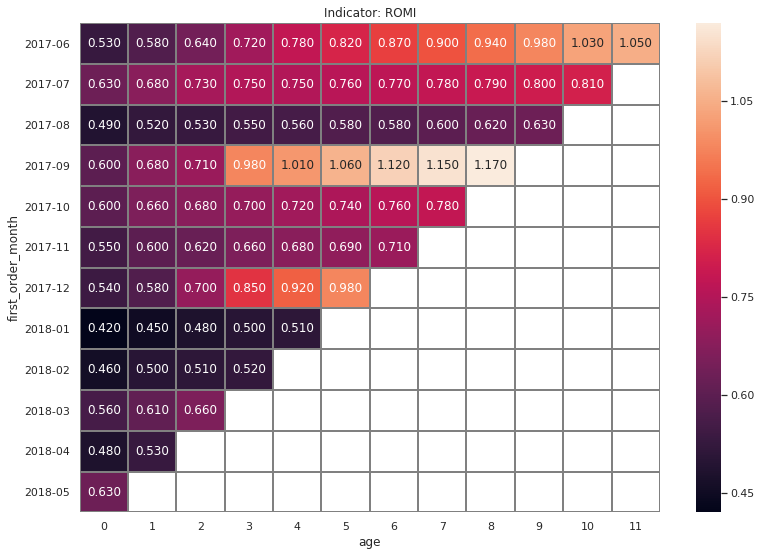

In [143]:
output_romi_reset_index = output_romi.reset_index()
month_romi = output_romi_reset_index['first_order_month'].dt.strftime('%Y-%m')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Indicator: ROMI')
sns.heatmap(output_romi, 
            annot=True, 
            fmt='.3f', 
            linewidths=1, 
            linecolor='gray', 
            yticklabels=month_romi);

Лишь сентябрьская и июньская кагорта показали высокую эффективность и окупились. Причём сентябрьская окуписаль на три месяца раньше декабрьской. Вероятно, это связано с какими-то особенностями клиентов привличенными в сентябрьский период.

<a class="anchor" id="0-bullet">

# Шаг 3. Вывод

* Наиболее выгодной платформой является desktop, ей пользуется наибольшее количество пользователей и эффективность возврата денежных средств выше (ROMI). Для инвестирования наиболее выгодными являются источники 1,2 и 5, т.к. объём возврат с них наибольший. 
* Большинство покупателей возращется редко, возврат составляет менее 10%. Т.е. большинство покупае в первые несколько деней и после не возращаются и не проводят вторичных покупок. Поэтому возможно имеется смысл сосредоточить внимание на повышение возврата клиентов.  

* Важным моментом, является то, наибольший объём прибыли приходящийся на месяцы с июня по октябрь и на декабрь, так же в эти месяцы наблюдается высокая прибыли и люди из этой кагорты приносят больший доход (LTV). На другие месяцы необходимо изменить маркетинговую стратегию, для увеличения конвертации в другие месяцы.